In [1]:
using Revise
using DrWatson

In [3]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342


In [5]:
using CairoMakie # Plots related stuff
using Turing, MCMCChains, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP # For collect_results

In this section we want to compare results and performance of ReactiveMP.jl with another probabilistic programming library which is called Turing.jl. Turing is a general probabilistic programming toolbox and does not use message passing for inference procedure, but sampling. Message passing has an advantage over sampling approach for conjugate models (which our linear gaussian state space model is) because it may fallback to analytically tractable update rules, where sampling cannot. 

### Data

In [23]:
params = let
    # Seed for reproducability
    seed = 123
    
    # Number of samples in dataset
    n = 10
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9]
    
    # Observation noise
    B = [0.05 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    @strdict seed n A B
end;

In [24]:
z, y = generate_data(HMMModel(), params);

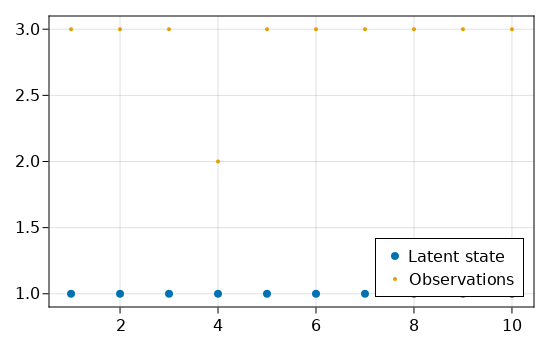

In [25]:
let 
    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1])
    
    range = 1:length(z)
    
    scatter!(ax, range, argmax.(z), markersize = 8, label = "Latent state")
    scatter!(ax, range, argmax.(y), markersize = 4, label = "Observations")
    
    axislegend(ax, position = :rb)
    
    fig
end

### Model specification

In [26]:
normalise(x) = x ./ sum(x)

normalise (generic function with 1 method)

In [30]:
@model BayesHmm(y, K) = begin
    # Get observation length.
    N = length(y)

    # State sequence.
    z = Turing.tzeros(Int, N)

    # Transition matrix.
    A = Vector{Vector}(undef, K)

    # Observations model matrix.
    B = Vector{Vector}(undef, K)

    # Assign distributions to each element of the transition matrix and the
    # emission matrix.
    for i = 1:K
        A_c_prior = normalise(ones(K))
        B_c_prior = ones(K)
        # B_c_prior[K - i + 1] = 10.0
        B_c_prior = normalise(B_c_prior)
        
        A[i] ~ Dirichlet(A_c_prior)
        B[i] ~ Dirichlet(B_c_prior)
    end

    # Observe each point of the input.
    z[1] ~ Categorical(K)
    y[1] ~ Categorical(vec(B[z[1]]))

    for i = 2:N
        z[i] ~ Categorical(vec(A[z[i - 1]]))
        y[i] ~ Categorical(vec(B[z[i]]))
    end
end;

### Inference

In [31]:
function inference_turing(observations; nsamples = 250, seed = 42)
    rng     = MersenneTwister(seed)
    sampler = Turing.Gibbs(Turing.HMC(0.1, 20, :A, :B), Turing.PG(100, :z))
    return Turing.sample(rng, BayesHmm(observations, 3), sampler, nsamples)
end

inference_turing (generic function with 1 method)

In [ ]:
z_turing_estimated = inference_turing(y);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/bvdmitri/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/bvdmitri/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/bvdmitri/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/bvdmitri/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

In [ ]:
summary = Turing.summarize(z_turing_estimated, Turing.mean, Turing.std);

In [ ]:
turing_z_means = map(i -> summary[Symbol("z[$i]")].nt.mean |> first, 1:length(z))
turing_z_stds = map(i -> summary[Symbol("z[$i]")].nt.std |> first, 1:length(z))

In [ ]:
let
    fig = Figure()

    ax = Axis(fig[1, 1])

    lines!(ax, turing_z_means)
    band!(ax, 1:n, turing_z_means .- turing_z_stds, turing_z_means .+ turing_z_stds )
    lines!(ax, float.(last.(findmax.(z_turing))))

    fig
end